In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
from functools import singledispatch, wraps
from inspect import getcallargs
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from asterism.base import buildmethod, checkmethod, Asterism
from asterism.utils import get_kwargs, kmeans
from asterism.utils.acts import Dirichlet
from asterism.utils.data import make_dataset
from asterism.utils.nets import ACT, OPTIM, Encoder, MLP
from asterism.utils.figs import show_dataset

In [2]:
class RNN(nn.Module):
    def __init__(self, channels, bias=True, act_layer='tanh'):
        super().__init__()

        self.channels = channels

        self._model = nn.RNN(self.channels, self.channels, nonlinearity=act_layer, bias=bias)

    def forward(self, n_layers, x=None, state=None):
        if x is None:
            x = torch.zeros(1, self.channels)

        if state is None:
            state = torch.zeros(1, self.channels)

        for i in range(1, n_layers + 1):
            x_, state_ = self._model(x[i - 1:i], state[i - 1:i])
            x, state = torch.cat([x, x_]), torch.cat([state, state_])

        return x[1:]
    
class RSB(Asterism, nn.Module):
    def __init__(self, min_topics=5, *, channels=(128, 32), kld_scale=.1, optim='adam', desc='RSB', seed=None):
        super().__init__(desc, seed)

        self.min_topics = min_topics
        self.channels = channels
        self.kld_scale = kld_scale
        self.optim = optim

        self._n_steps = 100

    def _build(self, X, learning_rate=1e-2, batch_size=128, shuffle=True):
        in_channels, self._batch_size, self.n_topics_ = X.shape[-1], batch_size, self.min_topics
        self._loader = DataLoader(X, batch_size, shuffle)
        self._encoder, self._dirichlet = Encoder(in_channels, *self.channels), Dirichlet()
        self._dt_model, self._tw_model = RNN(self.channels[-1]), RNN(self.channels[-1])
        self._decoder = MLP(self.channels[-1], in_channels, final_bias=False)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate)
        self.train()

        return self
    
    def _evaluate(self, X):
        z, kld = self._encoder(X, return_kld=True)
        dt_probs = self._dirichlet(z@self._dt_model(self.n_topics_ - 1).T)
        tw_probs = F.softmax(self._tw_model(self.n_topics_), -1)
        X_ = self._decoder(dt_probs@tw_probs)
        loss = (X_ - X).square().sum().sqrt() + self.kld_scale*kld

        return loss
    
    def _step(self):
        loss, self.n_topics_ = 0., self.min_topics

        for x in self._loader:
            x_loss = self._evaluate(x)
            x_loss.backward()
            loss += x_loss.item()

        self._optim.step()
        self._optim.zero_grad()

        return loss
    
    def _predict(self, X, eval=True):
        if eval:
            self.eval()

        topics = (X@self._decoder[0][0].weight.detach()).argmax(-1)

        return topics
    
    def forward(self, X, eval=True):
        topics = self._predict(X, eval)

        return topics

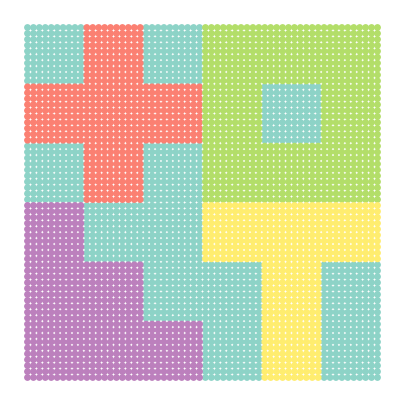

In [3]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

RSB: 100%|██████████| 1000/1000 [00:44<00:00, 22.44it/s]


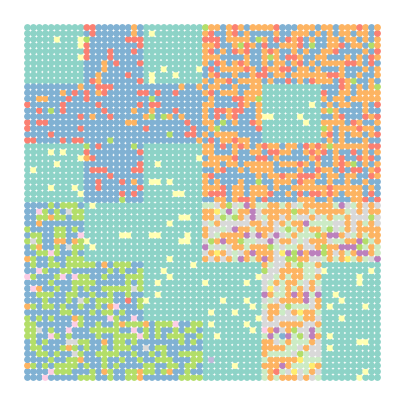

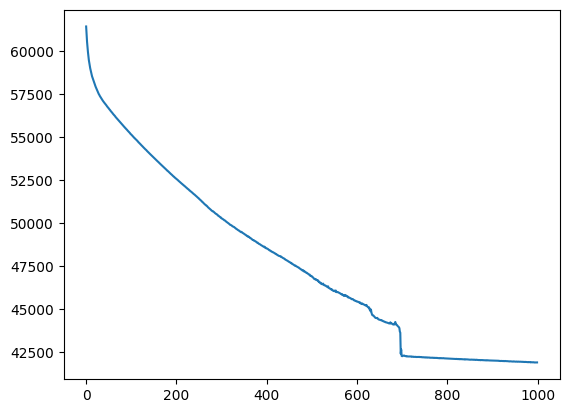

In [4]:
model = RSB(5)
topics = model.fit_predict(data[:, 3:], learning_rate=1e-3, n_steps=1000, batch_size=128)
show_dataset(data, topics)
plt.show()
plt.plot(range(len(model.log_)), model.log_)
plt.show()